# Explainability

In this notebook, our aim is to gain insight into how our neural networks classify images. We will concentrate on two techniques: intermediate activations and heatmaps. Our analysis will be limited to the best-performing neural networks identified in our previous experiments.

# Import and Costants

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from tensorflow.keras.preprocessing import image
from keras.models import Model
import pdb
import matplotlib.cm as cm

# Connection to Google Drive

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%run "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Utils.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will also handle the downloading and extraction of the dataset from the Google Drive folder.

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-split.zip" -d '/'

# Dataset loading
Next, we will create Dataset objects from the data stored in the sets directory, utilizing the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras.

In [5]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


# Model Loading
We load the best model for each type of network trained, including the CNN from scratch, VGG16, and ResNet. To evaluate a model's performance, we took into account its accuracy on the test set.

In [6]:
from_scratch_model = models.load_model(MODELS_PATH + '/Dense512Neurons_OneDropout0-3/Dense512Neurons_OneDropout0-3.h5')
vgg_model = models.load_model(MODELS_PATH + '/VGG16_LastBlockFineTuned/VGG16_LastBlockFineTuned.h5')
resnet_model = models.load_model(MODELS_PATH + '/ResNet50_Finetuned/ResNet50_Finetuned.h5')

Given that the VGG model has the base CNN network integrated as a single layer, it's important to extract the base CNN for working with its individual layer when dealing with heatmaps.

In [7]:
base_vgg = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_resnet = keras.applications.resnet.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

94765736/94765736 [==============================] - 0s 0us/step


We will load two images for analysis: one representing the "all" class and one specifically for the "hem" class.

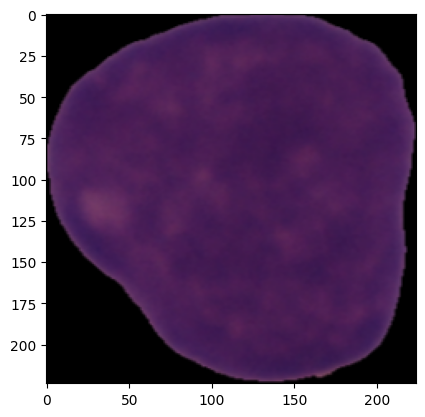

/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/all/UID_47_7_1_all.bmp


In [8]:
#all
first_image_all = os.listdir('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/all')[1]
img_path_all = '/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/all/' + first_image_all
# We preprocess the image into a 4D tensor (adding batch dimension)
img = image.load_img(img_path_all, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
img_tensor_all = image.img_to_array(img)
img_tensor_all = np.expand_dims(img_tensor_all, axis=0) # add batch dimension
plt.imshow(img_tensor_all[0].astype('uint8'))
plt.show()
print(img_path_all)

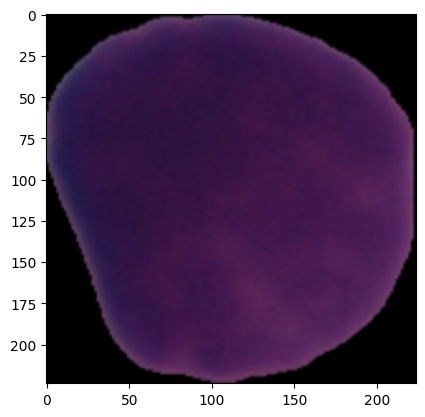

/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/hem/UID_H22_29_8_hem.bmp


In [9]:
#hem
first_image_hem = os.listdir('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/hem')[1]
img_path_hem = '/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/hem/' + first_image_hem
# We preprocess the image into a 4D tensor (adding batch dimension)
img = image.load_img(img_path_hem, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
img_tensor_hem = image.img_to_array(img)
img_tensor_hem = np.expand_dims(img_tensor_hem, axis=0) # add batch dimension
plt.imshow(img_tensor_hem[0].astype('uint8'))
plt.show()
print(img_path_hem)

# Visualizing intermediate activation
We will define the function to create the activation model from a base model and to display each activation in a grid.

In [10]:
def get_activation_model(model, base_model=0):
  layer_outputs = []
  layer_names = []
  if(base_model != 0):
    model = model.get_layer(base_model)
  for layer in model.layers:
      if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
          layer_outputs.append(layer.output)
          layer_names.append(layer.name)
  activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
  return activation_model, layer_names

def display_activations(activation_model, layer_names, img_tensor, images_per_row = 32, last_layer_to_show = 15):
  activations = activation_model.predict(img_tensor)
  # Now let's display our feature maps
  i = 0
  for layer_name, layer_activation in zip(layer_names, activations):

      i += 1
      #If this is the last layer to show we end the function
      if i >= last_layer_to_show and layer_name != layer_names[-1]:
        continue;

      # This is the number of features in the feature map
      n_features = layer_activation.shape[-1]

      # The feature map has shape (1, size, size, n_features)
      size = layer_activation.shape[1]

      # We will tile the activation channels in this matrix
      n_cols = n_features // images_per_row
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      # We'll tile each filter into this big horizontal grid
      for col in range(n_cols):
          for row in range(images_per_row):
              channel_image = layer_activation[0,:, :, col * images_per_row + row]
              # Post-process the feature to make it visually palatable
              channel_image -= channel_image.mean()
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

      # Display the grid
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='gray')

  plt.show()

img_tensor_cell = img_tensor_all

We construct the activation model for each of the loaded models.

In [11]:
from_scratch_activation_model, from_scratch_layer_names = get_activation_model(from_scratch_model)
vgg_activation_model, vgg_layer_names = get_activation_model(vgg_model, "vgg16")
resnet_activation_model, resnet_layer_names = get_activation_model(resnet_model, "resnet50")

In [12]:
vgg_layer_names[-1]

'block5_pool'

## CNN from scratch

In [13]:
from_scratch_activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                             

In [14]:
display_activations(from_scratch_activation_model, from_scratch_layer_names, img_tensor_cell)

Output hidden; open in https://colab.research.google.com to view.

## VGG16

In [15]:
display_activations(vgg_activation_model, vgg_layer_names, img_tensor_cell)

Output hidden; open in https://colab.research.google.com to view.

## Resnet-50

In [16]:
display_activations(resnet_activation_model, resnet_layer_names, img_tensor_cell)

Output hidden; open in https://colab.research.google.com to view.

# Heatmaps
Now we develope the heatmap for the all and for the hem cell.

In [17]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array


def get_last_conv_layer_index (model):
  index = 0
  i = 0
  for i, layer in enumerate(model.layers):
    if len(layer.output_shape) == 4: # we discriminate conv layer for the 4D dimension
      index = i
  return index

def get_first_classification_layer(model, base_model_name):
  next_is_good = False
  for layer in model.layers:
    if next_is_good:
      return layer
    if layer.name == base_model_name:
      next_is_good = True
  raise ValueError("Could not find BaseModel Layer")

def make_heatmap (img_array, model, base_model = 0):

  '''
  make_heatmap is used to create the heatmap that shows the gradient-weighted class activation mapping
  :param img_array: a numpy array that represents the image
  :param model: model considered
  :param last_conv_layer_index: index of the last convolutional layer of the model
  :param class_index: class of the image
  :return: the heatmap
  '''
  # We create a model that maps the input image to the activations of the last convolutional layer
  # And a model that maps the input image to the predictions
  if (base_model == 0):
    last_conv_layer_index = get_last_conv_layer_index(model)
    inputs_intermediate = model.inputs
    outputs_intermediate = model.layers[last_conv_layer_index + 1].input
    inputs_classifier = [model.layers[last_conv_layer_index + 1].input]
    outputs_classifier = model.output
  else:
    last_conv_layer_index = get_last_conv_layer_index(base_model)
    inputs_intermediate = base_model.inputs
    outputs_intermediate = base_model.layers[last_conv_layer_index].output
    inputs_classifier = get_first_classification_layer(model, base_model.name).input
    outputs_classifier = model.output
  intermediate_layer_model = keras.Model(inputs=inputs_intermediate, outputs=outputs_intermediate)
  classifier_model = Model(inputs=inputs_classifier, outputs=outputs_classifier)
  # We compute the gradient of the predictions with respect to the activations of the last convolutional layer
  with tf.GradientTape() as tape:
    last_conv_layer_output = intermediate_layer_model(img_array) # output feature maps of the last conv layer.
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])  #  "african elephant" index
    top_class_channel = preds[:, top_pred_index] # "african elephant" prediction value
  grads = tape.gradient(top_class_channel, last_conv_layer_output) # gradient of the "african elephant" class with regard to the output feature maps of our last conv layer

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately
  weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i] # the i-th feature map is weighted with the i-th gradient

  heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

def compute_gradcam(img_path, heatmap, alpha=0.4):
  '''
  compute_gradcam is used to superimpose the heatmap on top of the image
  :param img_path: where is located the image
  :param heatmap: heatmap precomputed
  :return: the superimposed image
  '''
  img = keras.preprocessing.image.load_img(img_path)
  img = keras.preprocessing.image.img_to_array(img)

  # rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  return superimposed_img

def display_gradcam(img_path, heatmap, alpha=0.4):
  '''
  display_gradcam is used to print the heatmap of class activations
  :param img_path: where is located the image
  :param heatmap: heatmap precomputed
  '''
  superimposed_img = compute_gradcam(img_path, heatmap, alpha)
  plt.figure(figsize= (10,10))
  plt.imshow(superimposed_img)


## All image

In [18]:
img_array = get_img_array(img_path_all, IMAGE_SIZE)

scratch_predictions = from_scratch_model.predict(img_array)
heatmap_scratch = make_heatmap(img_array, from_scratch_model)

vgg_predictions = vgg_model.predict(img_array)
heatmap_vgg = make_heatmap(img_array, vgg_model, base_vgg)

resnet_predictions = resnet_model.predict(img_array)
heatmap_resnet = make_heatmap(img_array, resnet_model)

1/1 [==============================] - 1s 542ms/step


1/1 [==============================] - 0s 360ms/step


1/1 [==============================] - 2s 2s/step


Text(0.5, 1.0, 'ResNet-50')

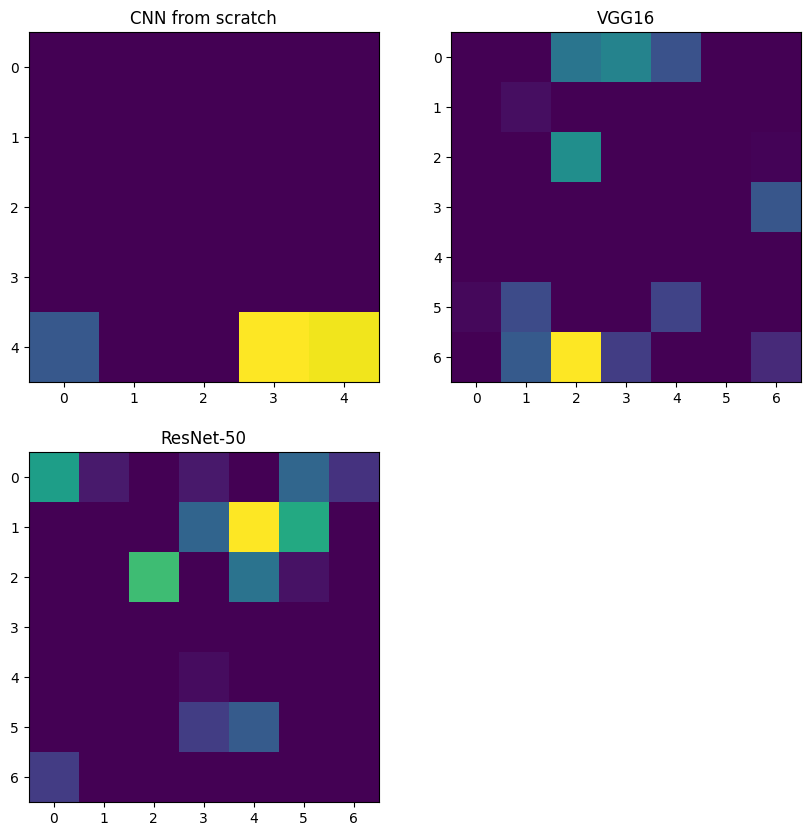

In [19]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 2, 1)
plt.imshow(heatmap_scratch)
plt.title("CNN from scratch")

fig.add_subplot(2, 2, 2)
plt.imshow(heatmap_vgg)
plt.title("VGG16")

fig.add_subplot(2, 2, 3)
plt.imshow(heatmap_resnet)
plt.title("ResNet-50")


In [20]:
scratch_gradcam = compute_gradcam(img_path_all, heatmap_scratch)
vgg_gradcam = compute_gradcam(img_path_all, heatmap_vgg)
resnet_gradcam = compute_gradcam(img_path_all, heatmap_resnet)

<ipython-input-17-8912a8cb852a>:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


Text(0.5, 1.0, 'ResNet-50')

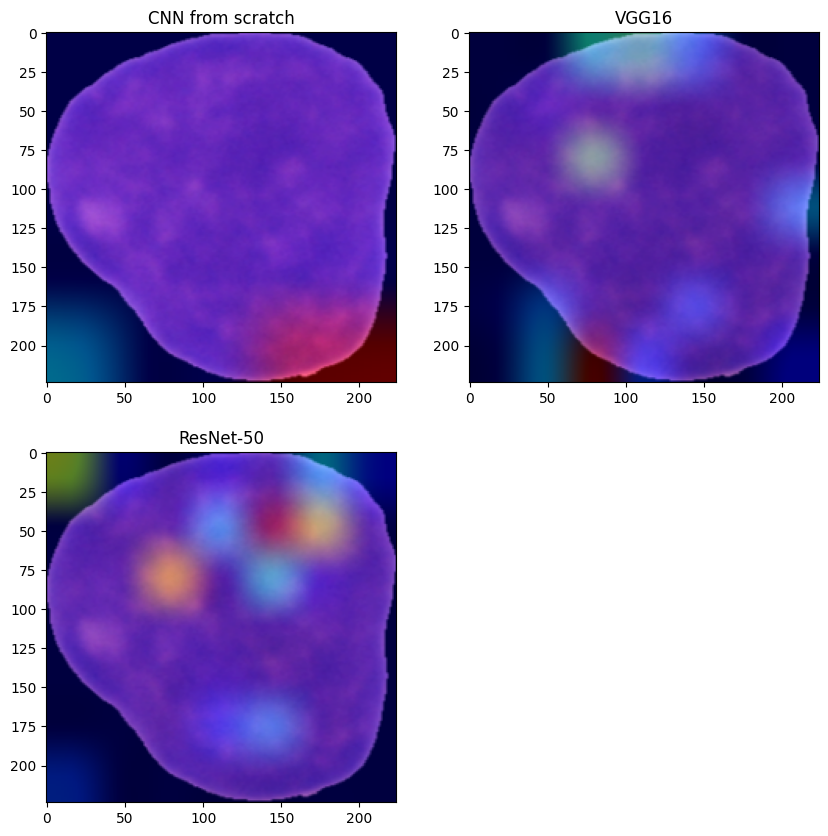

In [22]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 2, 1)
plt.imshow(scratch_gradcam)
plt.title("CNN from scratch")

fig.add_subplot(2, 2, 2)
plt.imshow(vgg_gradcam)
plt.title("VGG16")

fig.add_subplot(2, 2, 3)
plt.imshow(resnet_gradcam)
plt.title("ResNet-50")

## Hem image

In [23]:
img_array = get_img_array(img_path_hem, IMAGE_SIZE)

scratch_predictions = from_scratch_model.predict(img_array)
heatmap_scratch = make_heatmap(img_array, from_scratch_model)

vgg_predictions = vgg_model.predict(img_array)
heatmap_vgg = make_heatmap(img_array, vgg_model, base_vgg)

resnet_predictions = resnet_model.predict(img_array)
heatmap_resnet = make_heatmap(img_array, resnet_model)

1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'ResNet-50')

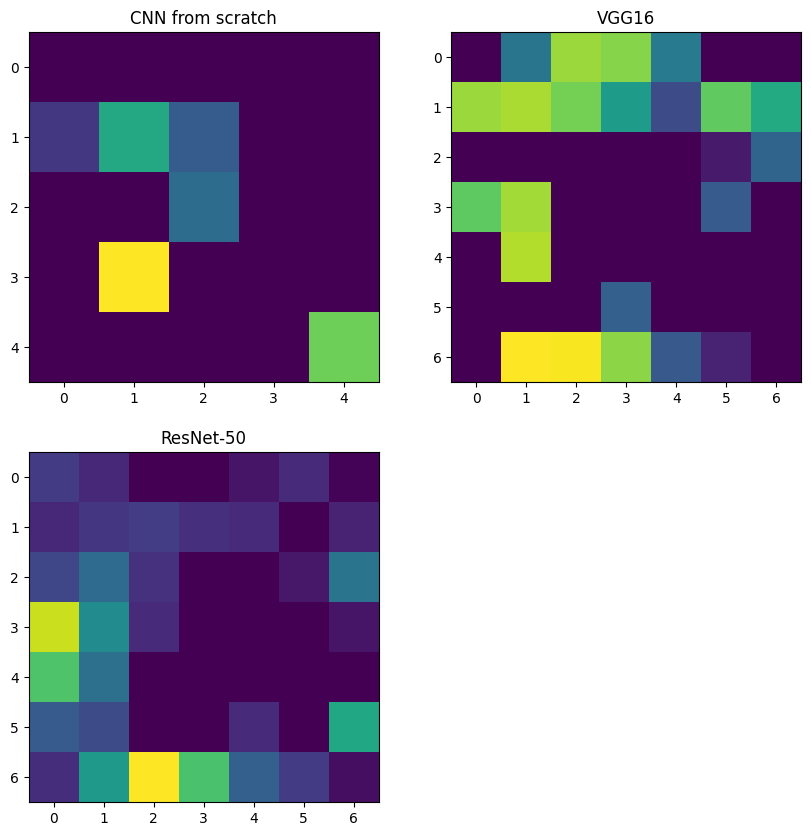

In [24]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 2, 1)
plt.imshow(heatmap_scratch)
plt.title("CNN from scratch")

fig.add_subplot(2, 2, 2)
plt.imshow(heatmap_vgg)
plt.title("VGG16")

fig.add_subplot(2, 2, 3)
plt.imshow(heatmap_resnet)
plt.title("ResNet-50")

In [25]:
scratch_gradcam = compute_gradcam(img_path_hem, heatmap_scratch)
vgg_gradcam = compute_gradcam(img_path_hem, heatmap_vgg)
resnet_gradcam = compute_gradcam(img_path_hem, heatmap_resnet)

<ipython-input-17-8912a8cb852a>:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


Text(0.5, 1.0, 'ResNet-50')

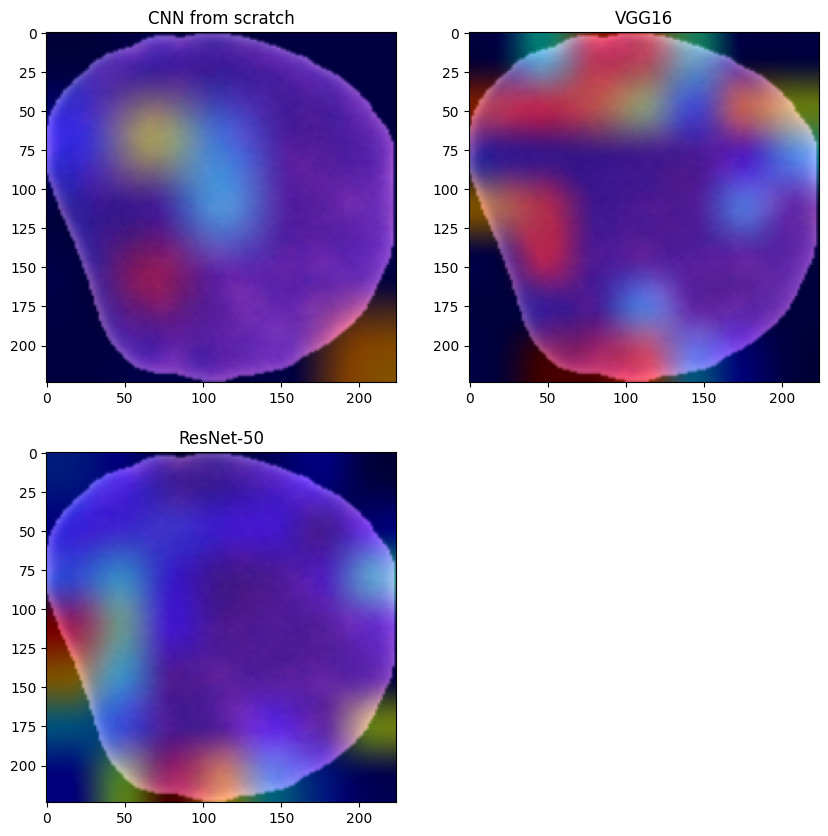

In [26]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 2, 1)
plt.imshow(scratch_gradcam)
plt.title("CNN from scratch")

fig.add_subplot(2, 2, 2)
plt.imshow(vgg_gradcam)
plt.title("VGG16")

fig.add_subplot(2, 2, 3)
plt.imshow(resnet_gradcam)
plt.title("ResNet-50")